In [7]:
import sys
sys.path.append("/Users/leah/Columbia/courses/19summer/microbialdynamics")

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

import os

%matplotlib inline

In [4]:
dat = np.loadtxt("taur-otu-table-filtered.csv", delimiter=",", dtype=str)

In [5]:
dat.shape

(773, 1158)

In [9]:
dat[1]

array(['day', '-9', '-4', ..., '17', '18', '19'], dtype='<U125')

# select top K obs

In [10]:
file2 = "taur-otu-table-filtered.csv"

In [13]:
f2 = pd.read_csv(file2, header=None)

In [14]:
data2 = f2.to_numpy()

In [15]:
measure_pid = f2.loc[0:0, 1:]
measure_pid = np.array(measure_pid, dtype=int)
measure_pid = measure_pid.reshape((-1))
f2pid = np.unique(measure_pid)

In [16]:
print("{} patients with id {}".format(len(f2pid), f2pid))

185 patients with id [  1   2  10  12  13  20  25  26  31  38  44  53  59  64  65  66  68  69
  70  74  75  76  88  93  96  97 113 115 121 126 137 146 151 155 166 167
 169 170 174 177 181 184 218 226 234 235 239 240 243 248 250 255 257 259
 263 267 270 272 279 283 286 294 295 302 304 305 306 315 321 327 329 333
 341 347 348 361 364 366 369 372 378 383 386 389 402 410 413 416 423 429
 436 444 447 448 449 460 462 463 466 467 480 491 495 497 498 500 501 502
 503 504 505 506 507 508 512 515 516 523 529 530 531 534 536 537 545 546
 551 552 559 565 566 572 577 590 593 600 602 604 605 606 608 620 622 623
 631 635 641 642 656 657 662 663 664 666 667 675 683 684 689 690 691 694
 697 698 704 705 706 708 710 715 718 721 723 725 736 738 746 747 748 750
 753 756 763 765 769]


In [17]:
count = data2[2:-1, 1:].T.astype(int)
print("count shape (measures, microbio speicies):", count.shape)
count_sum_across_spieces = np.sum(count, axis=1, keepdims=True)
percentage = count / count_sum_across_spieces

count shape (measures, microbio speicies): (1157, 770)


In [18]:
percentage_sum_across_measures = np.sum(percentage, axis=0)
spieces_name = data2[2:-1, 0]
k = 10
top_k_spieces_idx = np.argsort(percentage_sum_across_measures)[-k:][::-1]
print("top_k_spieces_idx:", top_k_spieces_idx)
for i, idx in enumerate(top_k_spieces_idx):
    print("top {:>2}, idx {:>4}, percentage_sum {:>5.2f}, name {}".format(i, idx, percentage_sum_across_measures[idx], spieces_name[idx]))

top_k_spieces_idx: [281 291 411 326 284 731  15  25 386 126]
top  0, idx  281, percentage_sum 223.82, name Bacteria;Firmicutes;Bacilli;Lactobacillales;Enterococcaceae;Enterococcus
top  1, idx  291, percentage_sum 139.93, name Bacteria;Firmicutes;Bacilli;Lactobacillales;Streptococcaceae;Streptococcus
top  2, idx  411, percentage_sum 127.12, name Bacteria;Firmicutes;Erysipelotrichia;Erysipelotrichales;Erysipelotrichaceae;Erysipelatoclostridium
top  3, idx  326, percentage_sum 110.75, name Bacteria;Firmicutes;Clostridia;Clostridiales;Lachnospiraceae;Blautia
top  4, idx  284, percentage_sum 55.71, name Bacteria;Firmicutes;Bacilli;Lactobacillales;Lactobacillaceae;Lactobacillus
top  5, idx  731, percentage_sum 37.63, name Bacteria;Verrucomicrobia;Verrucomicrobiae;Verrucomicrobiales;Akkermansiaceae;Akkermansia
top  6, idx   15, percentage_sum 30.37, name Bacteria;Actinobacteria;Actinobacteria;Actinomycetales;Actinomycetaceae;Actinomyces
top  7, idx   25, percentage_sum 27.04, name Bacteria;Ac

In [20]:
obs = []

dates = data2[1, 1:].astype(int)
percentage_obs = np.zeros((percentage.shape[0], k + 2))
percentage_obs[:, 0] = dates
percentage_obs[:, 1:-1] = percentage[:, top_k_spieces_idx]
percentage_obs[:, -1] = 1 - np.sum(percentage_obs[:, 1:], axis=-1)

pid_measure_start = 0
for pid in f2pid:
    patient_obs = []
    for i in range(pid_measure_start, len(measure_pid)):
        if measure_pid[i] != pid:
            pid_measure_start = i
            break
        patient_obs.append(percentage_obs[i])
    obs.append(np.asarray(patient_obs))
print(len(obs), obs[0].shape)

185 (3, 12)


In [23]:
type(obs)

list

array([[-9.00000000e+00,  1.12367021e-01,  2.28723404e-02,
         1.86170213e-03,  3.19414894e-01,  1.02792553e-01,
         0.00000000e+00,  5.31914894e-04,  3.98936170e-04,
         3.49734043e-02,  5.18617021e-03,  3.99601064e-01],
       [-4.00000000e+00,  1.50390625e-01,  1.85546875e-02,
         0.00000000e+00,  2.89062500e-01,  1.63085938e-01,
         0.00000000e+00,  9.76562500e-04,  4.68750000e-02,
         8.78906250e-02,  8.78906250e-03,  2.34375000e-01],
       [ 3.00000000e+00,  9.88185342e-01,  2.21524829e-03,
         3.69208049e-04,  9.23020122e-04,  1.84604024e-04,
         0.00000000e+00,  3.69208049e-04,  0.00000000e+00,
         5.53812073e-04,  0.00000000e+00,  7.19955695e-03]])

In [24]:
num_observed_days = np.array([ob.shape[0] for ob in obs])

In [25]:
num_observed_days

array([ 3,  3,  3,  5,  3,  4,  3, 20, 26,  4,  3,  4,  6,  3,  3,  3,  6,
        5,  3,  3,  6,  3,  3, 12,  5, 17,  4,  4,  3,  5,  4,  6,  3,  5,
        4,  5,  8,  4,  4,  3,  4,  3,  4,  3,  4,  3,  6,  3,  3,  5,  3,
        5,  4, 14,  3,  3,  3,  3,  3,  3,  3,  5,  3,  3,  3,  4,  3,  4,
        3,  4,  3,  5,  3,  3,  3,  3,  3,  5,  4,  5,  3,  3,  3,  4,  3,
        7,  3,  3,  4,  9, 11,  3, 20,  3,  4,  5,  3, 12,  4,  4, 10,  4,
        6,  3,  3,  4, 10,  6,  4, 14,  4,  3,  4,  3,  3, 21,  4, 10,  4,
       17, 27,  3,  3, 17,  3,  3, 21,  4,  3,  4,  7,  3,  4,  4,  6,  4,
        5,  3,  7,  5,  3,  5,  5,  4,  3,  3,  3, 17,  3,  3,  5,  4,  4,
        7,  4,  3,  3,  3,  3,  4,  3, 15, 16, 19, 25,  3,  3, 20,  9, 10,
       14, 18,  5, 14,  3,  3,  8, 17, 10,  9, 15, 13, 21, 20, 16])

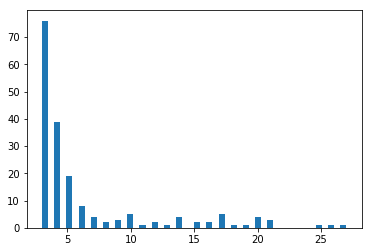

In [30]:
plt.hist(num_observed_days, bins=50);

In [34]:
num_observed_days[num_observed_days>5]

array([20, 26,  6,  6,  6, 12, 17,  6,  8,  6, 14,  7,  9, 11, 20, 12, 10,
        6, 10,  6, 14, 21, 10, 17, 27, 17, 21,  7,  6,  7, 17,  7, 15, 16,
       19, 25, 20,  9, 10, 14, 18, 14,  8, 17, 10,  9, 15, 13, 21, 20, 16])

In [33]:
len(num_observed_days[num_observed_days>5])

51

In [35]:
len(num_observed_days[num_observed_days>6])

43

In [36]:
len(num_observed_days[num_observed_days>7])

39

In [37]:
len(num_observed_days[num_observed_days>8])

37

In [38]:
len(num_observed_days[num_observed_days>9])

34

In [39]:
len(num_observed_days[num_observed_days>10])

29

In [40]:
type(obs)

list

In [70]:
import pickle

In [145]:
data_dir = "/Users/leah/Columbia/courses/19summer/microbialdynamics/data/count_microbio.p"

with open(data_dir, "rb") as f:
    data = pickle.load(f)

In [146]:
data.keys()

dict_keys(['Ytrain', 'Ytest', 'Vtrain', 'Vtest', 'counts_train', 'counts_test'])

In [147]:
obs_train = data['Ytrain']
obs_test = data['Ytest']
inputs_train = data['Vtrain']
inputs_test = data['Vtest']

In [148]:
obs = obs_train + obs_test
inputs = inputs_train + inputs_test

In [149]:
def interpolate_datapoint(obs, input):
    """

    :param obs: (n_obs, Dy + 1), [:, 0] records t of all obs
    :return:
    obs: (time, Dy)
    mask: (time, )
    time_interval: (time, )
    """
    days = obs[:, 0].astype(int)
    time = days[-1] - days[0] + 1

    mask = np.ones((time, ), dtype=bool)
    time_interval = np.zeros((time, ))

    i = 0
    for t in np.arange(days[0], days[-1] + 1):
        idx = t - days[0]
        if t == days[i]:
            i = i + 1
            time_interval[idx] = 0
        else:
            mask[t - days[0]] = False
            time_interval[idx] = time_interval[idx - 1] + 1

    # obs
    Dy = obs.shape[1] - 1

    interpolated_obs = np.zeros((time, Dy))
    last_valid_value = np.ones(Dy) / Dy
    i = 0
    for t in np.arange(days[0], days[-1] + 1):
        if t == days[i]:
            smoothed_obs = obs[i, 1:]
            interpolated_obs[t - days[0]] = smoothed_obs
            last_valid_value = smoothed_obs
            i += 1
        else:
            interpolated_obs[t - days[0]] = last_valid_value
            
    # inputs
    Dv = input.shape[1] - 1
    interpolated_input = np.zeros((time, Dv))
    for day_input in input:
        day = int(day_input[0])
        if days[0] <= day <= days[-1]:
            interpolated_input[day - days[0]] = day_input[1:]

    return interpolated_obs, interpolated_input, mask, time_interval

In [132]:
def interpolate_data(batch_obs, batch_inputs):
    
    interpolated_batch_obs = []
    interpolated_batch_inputs = []
    batch_mask = []
    batch_time_interval = []

    for obs, inputs in zip(batch_obs, batch_inputs):
        obs, inputs, mask, time_interval = interpolate_datapoint(obs, inputs)

        interpolated_batch_obs.append(obs)
        interpolated_batch_inputs.append(inputs)
        batch_mask.append(mask)
        batch_time_interval.append(time_interval)
        

    return interpolated_batch_obs, interpolated_batch_inputs, batch_mask, batch_time_interval

In [133]:
new_obs, new_inputs, masks, time_interval = interpolate_data(obs, inputs)

In [134]:
type(new_obs)

list

In [135]:
len(new_obs)

108

In [136]:
def bar_plot(ax, obs, mask, to_normalize=True,):
    if to_normalize:
            obs = obs / np.sum(obs, axis=-1, keepdims=True)

    time, Dy = obs.shape

    # make missing obs = 0
    masked_obs = np.zeros_like(obs)
    masked_obs[mask] = obs[mask]
    
    ax.set_xlabel("Time")
    bottom = np.zeros(time)
    for j in range(Dy):
        ax.bar(np.arange(time), masked_obs[:, j], bottom=bottom, edgecolor='white')
        bottom += masked_obs[:, j]

    ax.set_xticks(np.arange(time))
    sns.despine()
    
def input_plot(ax, inputs):
    time, Dv = inputs.shape
    
    for j in range(Dv):
        has_inputs = inputs[:,j]== 1
        idx = np.arange(time)[has_inputs]
        ax.bar(idx, [1 for _ in idx], bottom=[j for _ in idx], color='blue')
    
    ax.set_xticks(np.arange(time))
    ax.set_yticks(np.arange(Dv))
    sns.despine()

    
def plot_inputs_and_obs(obs, input, mask, to_normalize=True):
    plt.figure(figsize=(15,10))

    ax1= plt.subplot(2,1,1)
    input_plot(ax1, input)
    ax1.grid()

    ax2 = plt.subplot(2,1,2, sharex = ax1)
    bar_plot(ax2, obs, mask, to_normalize=to_normalize)
    ax2.grid()

In [137]:
rslt_dir = "visualizations/microbio_longer/"

if not os.path.exists(rslt_dir):
    os.mkdir(rslt_dir)

In [138]:
for i in range(len(new_obs)):
    plot_inputs_and_obs(new_obs[i], new_inputs[i], masks[i])
    plt.savefig(rslt_dir + "sample_{}".format(i))
    plt.close()

In [54]:
len(masks)

185

In [57]:
len(new_obs)

185

In [139]:
new_inputs[0].shape

(20, 16)

In [140]:
inputs[0].shape

(20, 17)

In [126]:
new_inputs[0][0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [141]:
len(obs_train)

90

In [150]:
len(obs_test)

18

In [15]:
data_dir = "/Users/leah/Columbia/courses/19summer/microbialdynamics/data/clv/diff_percentage/clv_count_Dx_6_obsp_06.p"

In [16]:
with open(data_dir, "rb") as f:
    data = pickle.load(f)
    f.close()

In [17]:
data.keys()

dict_keys(['Xtrain', 'Xtest', 'Ytrain', 'Ytest', 'Vtrain', 'Vtest', 'counts_train', 'counts_test', 'A', 'g', 'W1', 'W2', 'f_cov', 'N'])

In [18]:
len(data['Ytrain'])

200

In [19]:
len(data['counts_train'])

200

In [21]:
data['counts_train'][0].shape

(27,)

In [25]:
data['Ytrain'][0].shape

(27, 8)

In [34]:
for i in range(len(data['Ytrain'])):
    assert(np.all(data['Ytrain'][i][:,1:].sum(axis=-1) == data['counts_train'][i]))

In [35]:
for i in range(len(data['Ytest'])):
    assert(np.all(data['Ytest'][i][:,1:].sum(axis=-1) == data['counts_test'][i]))

In [36]:
x = np.array([1,2])

In [37]:
y = x

In [39]:
y is x

True

In [40]:
y == x

array([ True,  True])

In [41]:
y = np.array(x)

In [42]:
y == x

array([ True,  True])

In [43]:
y is x

False

In [44]:
def test_l(obs):
    obs[0] = 1
    obs[1] = 2
    return obs

In [45]:
obs = [2,3]

In [46]:
out = test_l(obs)

In [47]:
out

[1, 2]

In [48]:
obs

[1, 2]

In [49]:
sttr = "haha_Dx_2"

In [55]:
sttr.find("Dx")

5

In [59]:
int(sttr[5+3])

2